In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import glob
import os 

%matplotlib inline

# Relief Visualization Toolbox (RVT)

In [1]:
import rvt.vis
import rvt.default

/N/u/amanagar/Carbonate/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## high-pass

(2.5, 2.5) 2.5 2.5 nan


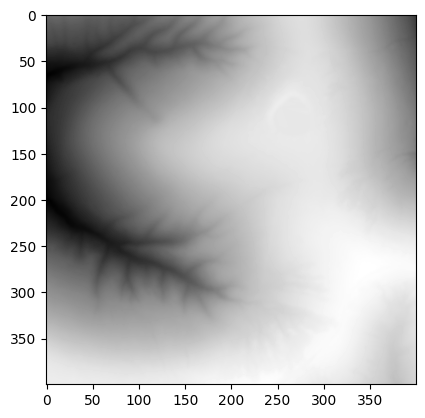

In [4]:
dem_path = f'../data/dem_files/in2017_01251380_12.img'
dict_dem = rvt.default.get_raster_arr(dem_path)
dem_arr = dict_dem["array"]  # numpy array of DEM
dem_resolution = dict_dem["resolution"]
dem_res_x = dem_resolution[0]  # resolution in X direction
dem_res_y = dem_resolution[1]  # resolution in Y direction
dem_no_data = np.nan #dict_dem["no_data"]

print(dem_resolution, dem_res_x, dem_res_y, dem_no_data)
plt.imshow(dem_arr[:400, :400], cmap='gray');

In [5]:
def lowPass(z, l0):
    #create a low-pass filter that smooths topography using a Gaussian kernel
    lY, lX = np.shape(z)
    x, y = np.arange(-lX/2, lX/2), np.arange(-lY/2, lY/2)
    X, Y = np.meshgrid(x, y)
    filt = 1/(2*np.pi*l0**2)*np.exp(-(X**2 + Y**2)/(2*l0**2))
    ftFilt = np.fft.fft2(filt)
    ftZ = np.fft.fft2(z)
    ftZNew = ftZ*ftFilt
    zNew = np.fft.ifft2(ftZNew).real
    zNew = np.fft.fftshift(zNew)
    return(zNew)

In [6]:
pad = 15
dem_arr_pad = np.pad(dem_arr, pad, mode='edge')
dem_arr_pad.shape

(2030, 2030)

In [7]:
z = dem_arr_pad*0.3048
lPass = lowPass(z, 2.5)
hPass = (z - lPass)
hPass = hPass[pad:-pad, pad:-pad]
hPass = np.clip(hPass, -0.75, 0.75).astype('float16')

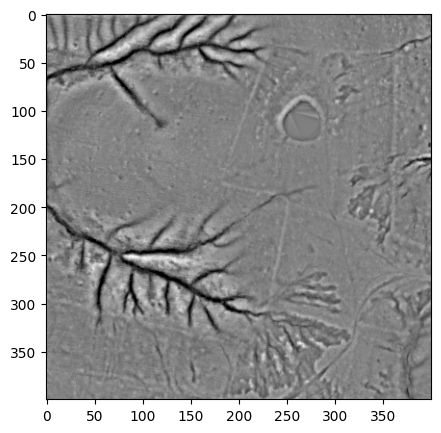

In [8]:
plt.figure(figsize=(5, 5))
plt.imshow(hPass[:400, :400], cmap='gray');

## Slope
https://rvt-py.readthedocs.io/en/latest/examples/rvt_vis_example.html#Slope

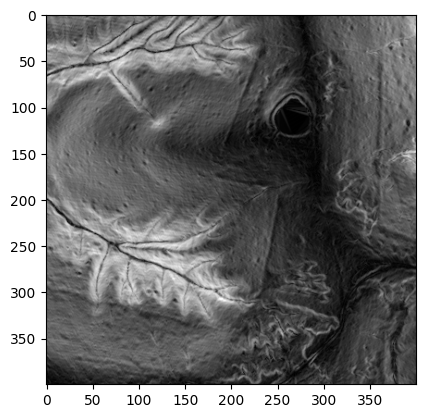

In [9]:
dict_slope_aspect = rvt.vis.slope_aspect(dem=dem_arr, resolution_x=dem_res_x, resolution_y=dem_res_y,
                                         output_units="degree", ve_factor=1, no_data=dem_no_data)
slope_arr = dict_slope_aspect["slope"]

plt.imshow(slope_arr[:400, :400], cmap='gray');

## Hillshade
https://rvt-py.readthedocs.io/en/latest/examples/rvt_vis_example.html#Hillshade

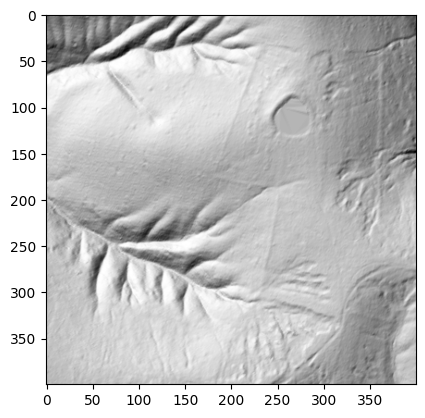

In [10]:
sun_azimuth = 315  # Solar azimuth angle (clockwise from North) in degrees
sun_elevation = 45  # Solar vertical angle (above the horizon) in degrees
hillshade_arr = rvt.vis.hillshade(dem=dem_arr, resolution_x=dem_res_x, resolution_y=dem_res_y,
                                  sun_azimuth=sun_azimuth, sun_elevation=sun_elevation, ve_factor=1)

plt.imshow(hillshade_arr[:400, :400], cmap='gray');

## Multi-Scale Relief Model (MSRM)
https://rvt-py.readthedocs.io/en/latest/examples/rvt_vis_example.html#Multi-Scale-Relief-Model-(MSRM)

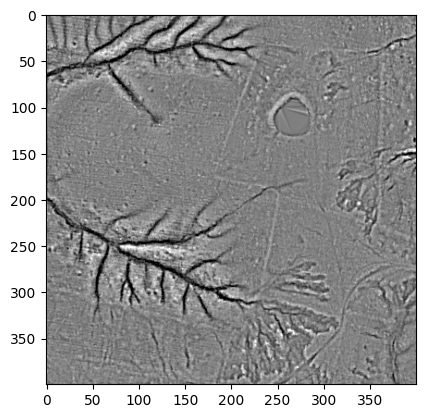

In [11]:
feature_min = 1  # minimum size of the feature you want to detect in meters
feature_max = 10  # maximum size of the feature you want to detect in meters
scaling_factor = 1  # scaling factor
msrm_arr = rvt.vis.msrm(dem=dem_arr, resolution=dem_res_x, feature_min=feature_min, feature_max=feature_max,
                        scaling_factor=scaling_factor, ve_factor=1, no_data=dem_no_data)

msrm_arr = np.clip(msrm_arr, -0.5, 0.5)

plt.imshow(msrm_arr[:400, :400], cmap='gray');

## Negative Openness
https://rvt-py.readthedocs.io/en/latest/examples/rvt_vis_example.html#Negative-openness

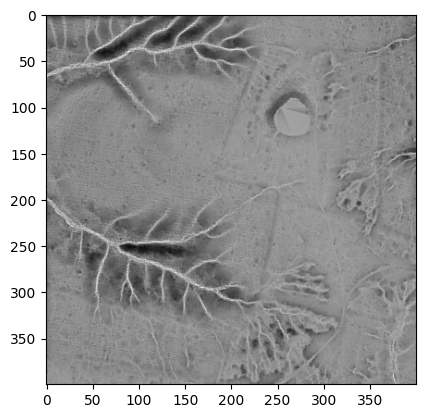

In [13]:
# svf, sky-view factor parameters which also applies to asvf and opns
svf_n_dir = 16  # number of directions
svf_r_max = 10  # max search radius in pixels
svf_noise = 0  # level of noise remove (0-don't remove, 1-low, 2-med, 3-high)
dem_arr_neg_opns = dem_arr * -1  # dem * -1 for neg opns
# we don't need to calculate svf and asvf (compute_svf=False, compute_asvf=False)
dict_svf = rvt.vis.sky_view_factor(dem=dem_arr_neg_opns, resolution=dem_res_x, compute_svf=False, compute_asvf=False, compute_opns=True,
                                   svf_n_dir=svf_n_dir, svf_r_max=svf_r_max, svf_noise=svf_noise,
                                   no_data=dem_no_data)
neg_opns_arr = dict_svf["opns"]
plt.imshow(neg_opns_arr[:400, :400], cmap='gray')

## Sky-view factor, anisotropic sky-view factor & positive openness
https://rvt-py.readthedocs.io/en/latest/examples/rvt_vis_example.html#Sky-view-factor,-anisotropic-sky-view-factor-&-positive-openness

In [14]:
# svf, sky-view factor parameters which also applies to asvf and opns
svf_n_dir = 16  # number of directions
svf_r_max = 5  # max search radius in pixels
svf_noise = 0  # level of noise remove (0-don't remove, 1-low, 2-med, 3-high)
# asvf, anisotropic svf parameters
asvf_level = 1  # level of anisotropy (1-low, 2-high)
asvf_dir = 315  # direction of anisotropy in degrees
dict_svf = rvt.vis.sky_view_factor(dem=dem_arr, resolution=dem_res_x, compute_svf=True, compute_asvf=True, compute_opns=True,
                                   svf_n_dir=svf_n_dir, svf_r_max=svf_r_max, svf_noise=svf_noise,
                                   asvf_level=asvf_level, asvf_dir=asvf_dir,
                                   no_data=dem_no_data)
svf_arr = dict_svf["svf"]  # sky-view factor
asvf_arr = dict_svf["asvf"]  # anisotropic sky-view factor
opns_arr = dict_svf["opns"]  # positive openness

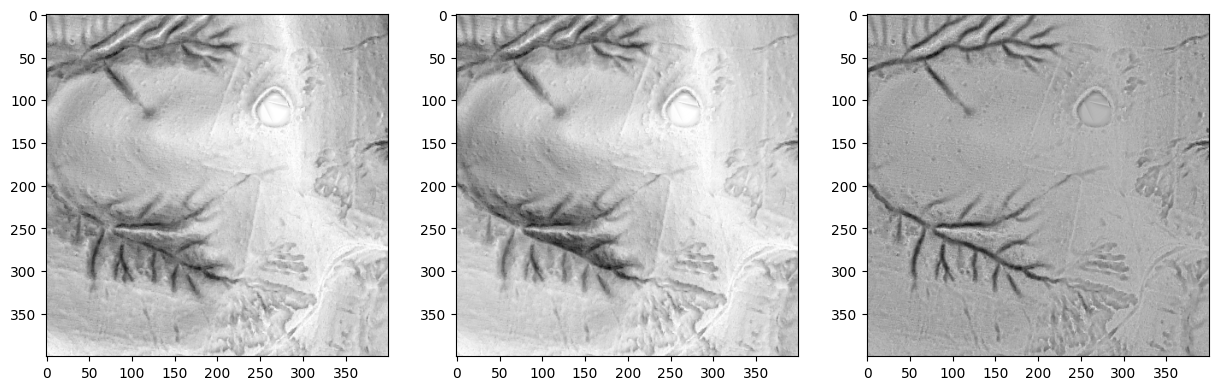

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(svf_arr[:400, :400], cmap='gray')
ax[1].imshow(asvf_arr[:400, :400], cmap='gray')
ax[2].imshow(opns_arr[:400, :400], cmap='gray')

# Create overlapping labels

## left-right

In [16]:
def get_patch(fname):
    img = Image.open(fname)
    return np.array(img)

def get_boxes(fname):
    try:
        with open(fname) as f:
            label = f.read().strip().split('\n')
        boxes = list(map(lambda x: [round(float(i), 5) for i in x.split(' ')[1:]], label))
        boxes = np.array(boxes) * 400
        if boxes.any():
            return boxes
        return np.array([])
    except FileNotFoundError:
        return np.array([])

In [19]:
left = get_patch('../dataset-train/images_jpg/in2017_01251380_12_0_0.jpg')
right = get_patch('../dataset-train/images_jpg/in2017_01251380_12_0_400.jpg')

In [20]:
left_lab = get_boxes('../dataset-train/labels/in2017_01251380_12_0_0.txt')
right_lab = get_boxes('../dataset-train/labels/in2017_01251380_12_0_400.txt')

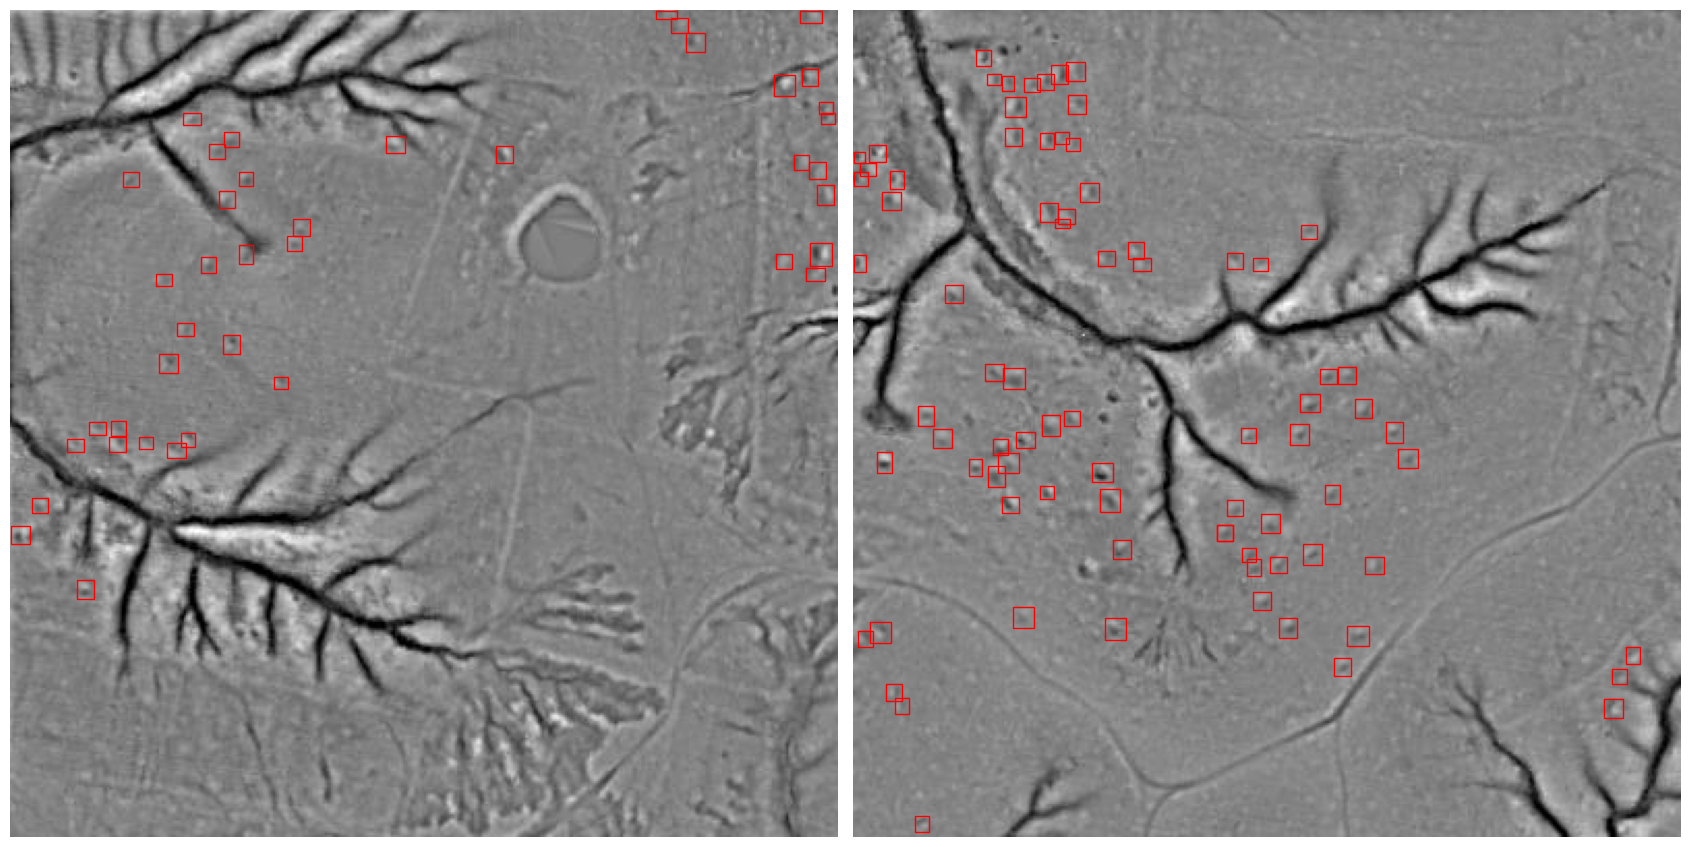

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(17, 12))

ax[0].imshow(left, cmap='gray')
ax[0].axis('off')

for box in left_lab:
    rect = patches.Rectangle(
        (box[0]-box[2]/2, box[1]-box[3]/2), 
        box[2], box[3], linewidth=1, edgecolor='r', facecolor='none'
    )
    ax[0].add_patch(rect)

ax[1].imshow(right, cmap='gray')
ax[1].axis('off')

for box in right_lab:
    rect = patches.Rectangle(
        (box[0]-box[2]/2, box[1]-box[3]/2), 
        box[2], box[3], linewidth=1, edgecolor='r', facecolor='none'
    )
    ax[1].add_patch(rect)
    
plt.tight_layout()

In [22]:
im_size = 400
stride_x = 100

In [23]:
mid_lab_left = list(map(
    lambda x : [x[0] - stride_x] + x[1:], filter(
        lambda x: x[0] - x[2] > stride_x, left_lab.tolist()
        )
    )
)

mid_lab_right = list(map(
    lambda x : [x[0] + (im_size - stride_x)] + x[1:], filter(
        lambda x: x[0] + x[2] < stride_x, right_lab.tolist()
        )
    )
)

mid_lab = mid_lab_left + mid_lab_right

In [24]:
mid_img = np.hstack([left[:, stride_x:], right[:, :stride_x]])
mid_img.shape

(400, 400)

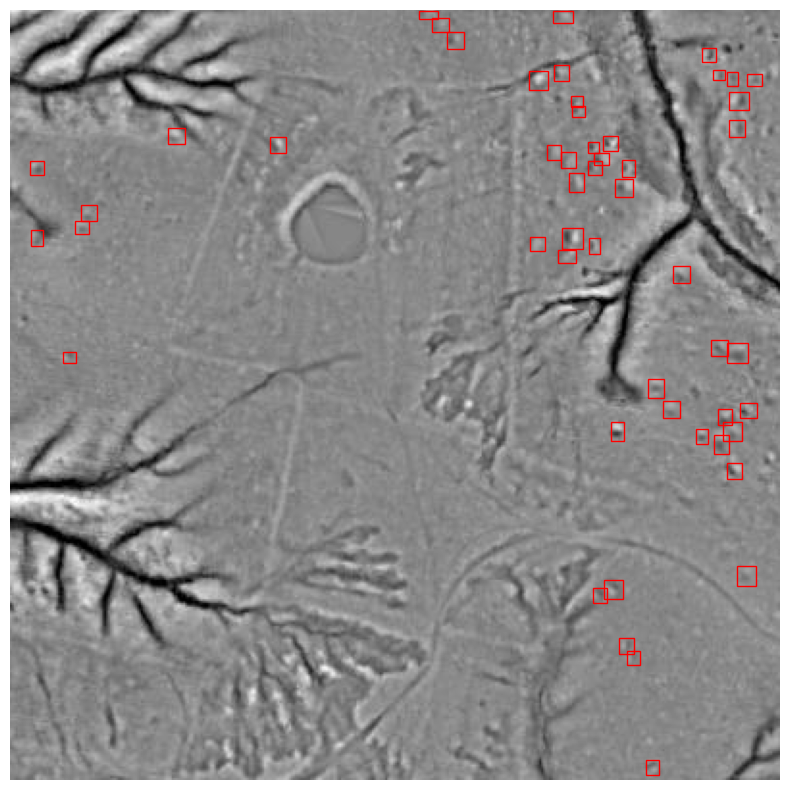

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.imshow(mid_img, cmap='gray')
ax.axis('off')

for box in mid_lab:
    rect = patches.Rectangle(
        (box[0]-box[2]/2, box[1]-box[3]/2), 
        box[2], box[3], linewidth=1, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    
plt.tight_layout()

## top-bottom

In [26]:
top = get_patch('../dataset-train/images_jpg/in2017_01251380_12_0_400.jpg')
bottom = get_patch('../dataset-train/images_jpg/in2017_01251380_12_400_400.jpg')

In [27]:
top_lab = get_boxes('../dataset-train/labels/in2017_01251380_12_0_400.txt')
bottom_lab = get_boxes('../dataset-train/labels/in2017_01251380_12_400_400.txt')

In [ ]:
stride_y = 300

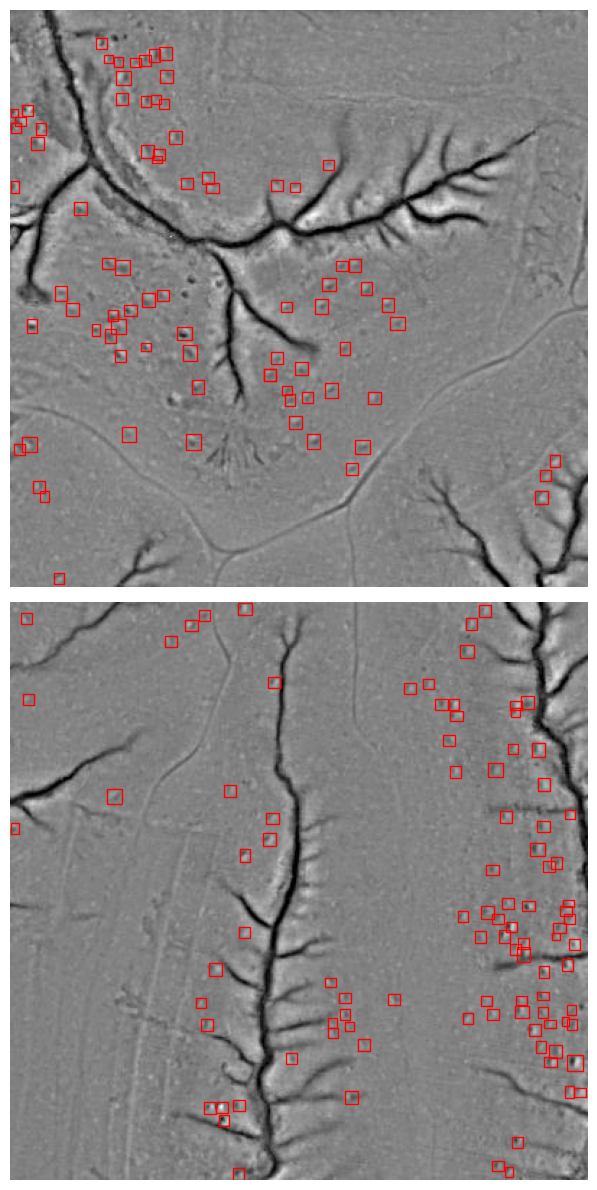

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(17, 12))

ax[0].imshow(top, cmap='gray')
ax[0].axis('off')

for box in top_lab:
    rect = patches.Rectangle(
        (box[0]-box[2]/2, box[1]-box[3]/2), 
        box[2], box[3], linewidth=1, edgecolor='r', facecolor='none'
    )
    ax[0].add_patch(rect)

ax[1].imshow(bottom, cmap='gray')
ax[1].axis('off')

for box in bottom_lab:
    rect = patches.Rectangle(
        (box[0]-box[2]/2, box[1]-box[3]/2), 
        box[2], box[3], linewidth=1, edgecolor='r', facecolor='none'
    )
    ax[1].add_patch(rect)
    
plt.tight_layout()

In [29]:
mid_lab_top = list(map(
    lambda x : x[:1] + [x[1] - stride_y] + x[2:], filter(
        lambda x: x[1] - x[3] > stride_y, top_lab.tolist()
        )
    )
)

mid_lab_bottom = list(map(
    lambda x : x[:1] + [x[1] + (im_size - stride_y)] + x[2:], filter(
        lambda x: x[1] + x[3] < stride_y, bottom_lab.tolist()
        )
    )
)

mid_lab = mid_lab_top + mid_lab_bottom

In [30]:
mid_img = np.vstack([top[stride_y:], bottom[:stride_y]])
mid_img.shape

(400, 400)

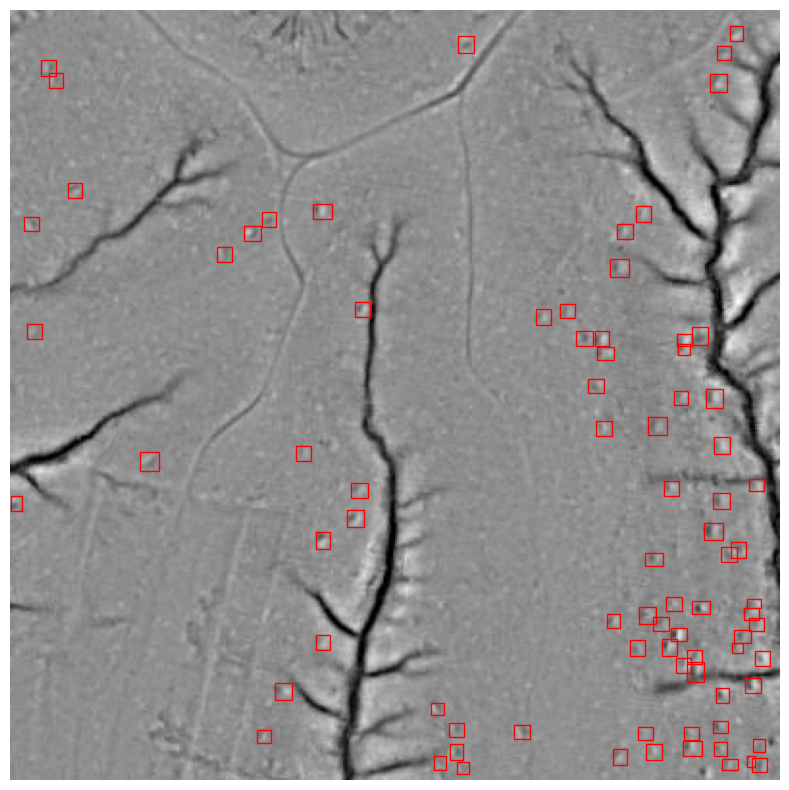

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.imshow(mid_img, cmap='gray')
ax.axis('off')

for box in mid_lab:
    rect = patches.Rectangle(
        (box[0]-box[2]/2, box[1]-box[3]/2), 
        box[2], box[3], linewidth=1, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    
plt.tight_layout()

## diagonal

In [34]:
top_left = get_patch('../dataset-train/images_jpg/in2017_01251380_12_800_1200.jpg')
top_right = get_patch('../dataset-train/images_jpg/in2017_01251380_12_800_1600.jpg')
bottom_left = get_patch('../dataset-train/images_jpg/in2017_01251380_12_1200_1200.jpg')
bottom_right = get_patch('../dataset-train/images_jpg/in2017_01251380_12_1200_1600.jpg')

In [35]:
top_left_lab = get_boxes('../dataset-train/labels/in2017_01251380_12_800_1200.txt')
top_right_lab = get_boxes('../dataset-train/labels/in2017_01251380_12_800_1600.txt')
bottom_left_lab = get_boxes('../dataset-train/labels/in2017_01251380_12_1200_1200.txt')
bottom_right_lab = get_boxes('../dataset-train/labels/in2017_01251380_12_1200_1600.txt')

In [43]:
stride_x, stride_y = 200, 350
im_size = 400

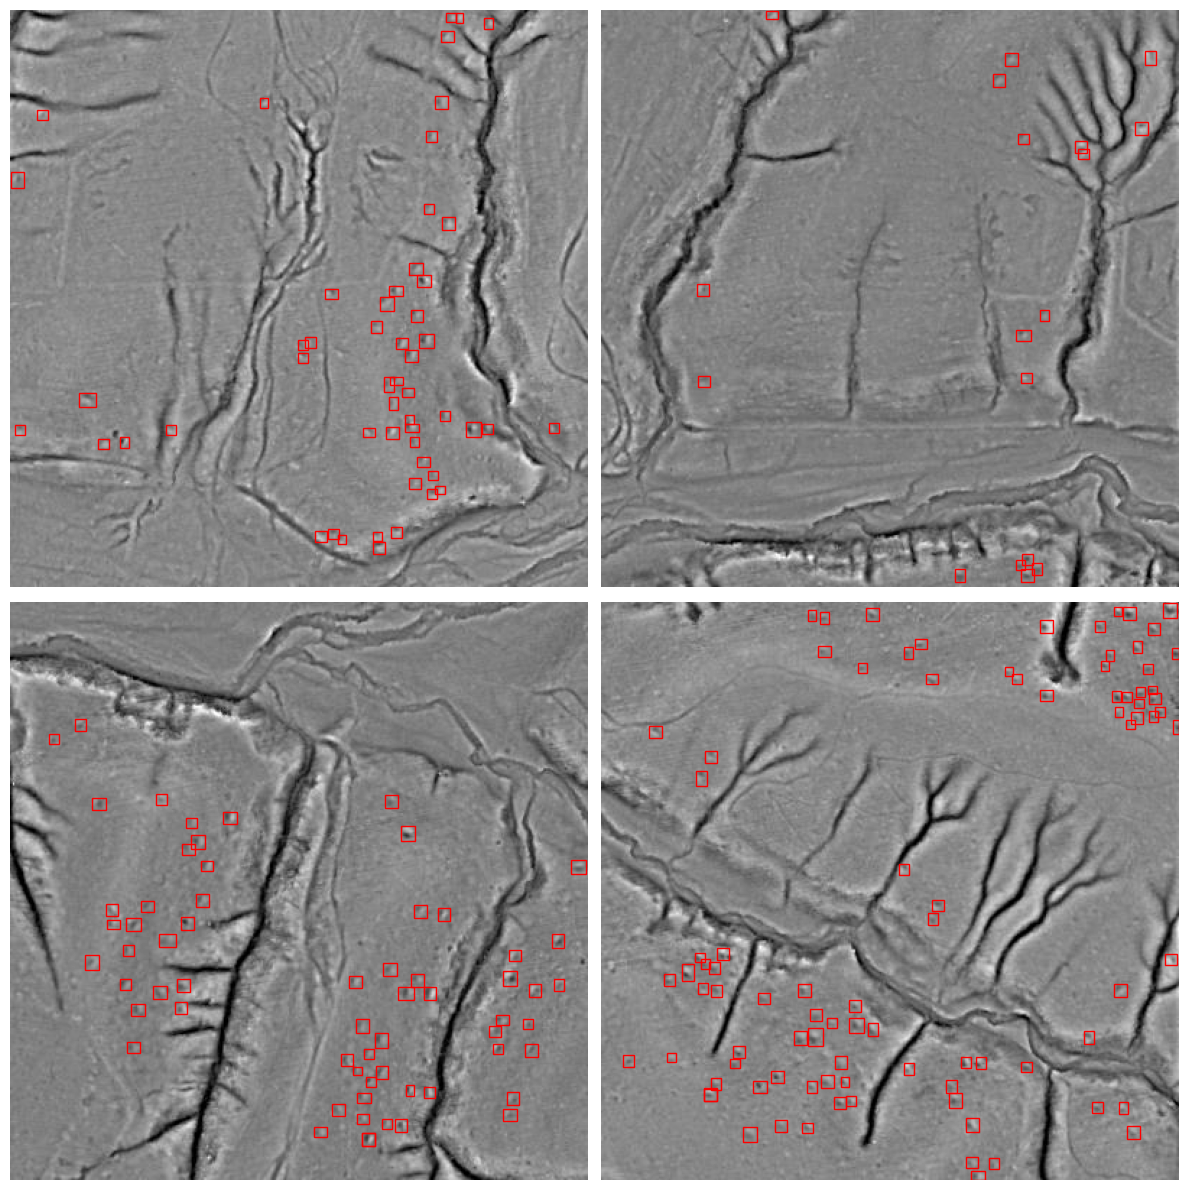

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

batch = [top_left, top_right, bottom_left, bottom_right]
batch_lab = [top_left_lab, top_right_lab, bottom_left_lab, bottom_right_lab]
idx = 0
for i in range(2):
    for j in range(2):
        ax[i, j].imshow(batch[idx], cmap='gray')
        ax[i, j].axis('off')

        for box in batch_lab[idx]:
            rect = patches.Rectangle(
                (box[0]-box[2]/2, box[1]-box[3]/2), 
                box[2], box[3], linewidth=1, edgecolor='r', facecolor='none'
            )
            ax[i, j].add_patch(rect)
        idx += 1

plt.tight_layout()

In [45]:
mid_lab_top_left = list(map(
    lambda x : [x[0] - stride_y] + [x[1] - stride_x] + x[2:], filter(
        lambda x: (x[0] - x[2] > stride_y) and (x[1] - x[3] > stride_x), top_left_lab.tolist()
        )
    )
)

mid_lab_top_right = list(map(
    lambda x : [x[0] + (im_size - stride_y)] + [x[1] - stride_x] + x[2:], filter(
        lambda x: (x[0] + x[2] < stride_y) and (x[1] - x[3] > stride_x), top_right_lab.tolist()
        )
    )
)

mid_lab_bottom_left = list(map(
    lambda x : [x[0] - stride_y] + [x[1] + (im_size - stride_x)] + x[2:], filter(
        lambda x: (x[0] - x[2] > stride_y) and (x[1] + x[3] < stride_x), bottom_left_lab.tolist()
        )
    )
)

mid_lab_bottom_right = list(map(
    lambda x : [x[0] + (im_size - stride_y)] + [x[1] + (im_size - stride_x)] + x[2:], filter(
        lambda x: (x[0] + x[2] < stride_y) and (x[1] + x[3] < stride_x), bottom_right_lab.tolist()
        )
    )
)

mid_lab = mid_lab_top_left + mid_lab_top_right + mid_lab_bottom_left + mid_lab_bottom_right

In [46]:
mid_img = np.hstack([np.vstack([top_left[stride_x:, stride_y:], bottom_left[:stride_x, stride_y:]]), 
                    np.vstack([top_right[stride_x:, :stride_y], bottom_right[:stride_x, :stride_y]])])
mid_img.shape

(400, 400)

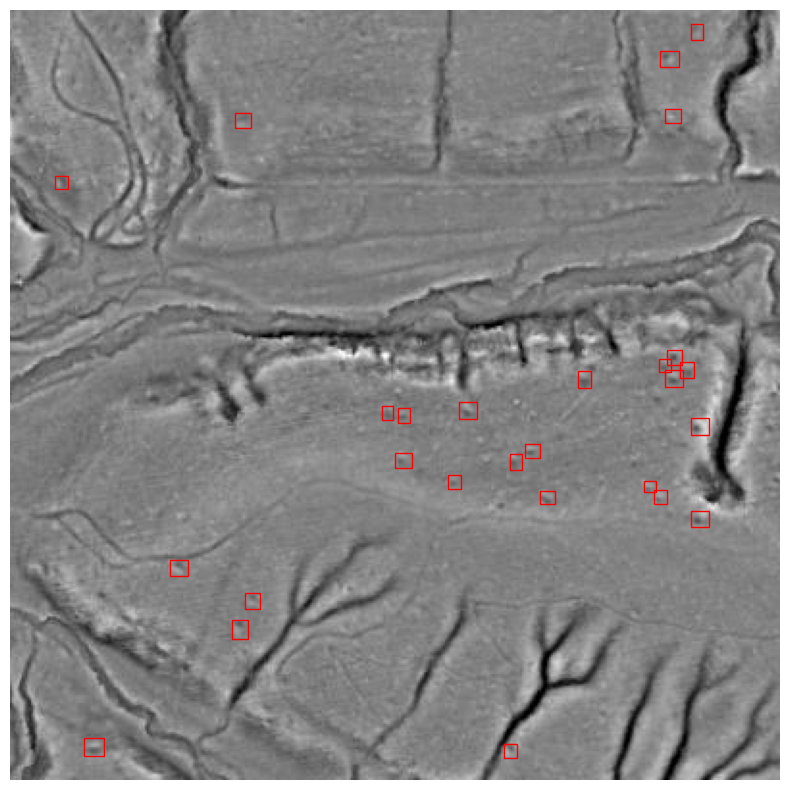

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.imshow(mid_img, cmap='gray')
ax.axis('off')

for box in mid_lab:
    rect = patches.Rectangle(
        (box[0]-box[2]/2, box[1]-box[3]/2), 
        box[2], box[3], linewidth=1, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    
plt.tight_layout()

# Label characteristics

In [49]:
all_images = sorted(os.listdir('../data/dem_files/'))
len(all_images)

39

In [61]:
def get_boxes(fname):
    try:
        with open(fname) as f:
            label = f.read().strip().split('\n')
        boxes = list(map(lambda x: [round(float(i), 5) for i in x.split(' ')[1:]], label))
        boxes = np.array(boxes) * 400
        if boxes.any():
            return boxes
        return np.array([])
    except FileNotFoundError:
        return np.array([])

In [62]:
count = {k[:-4]: 0 for k in all_images}
for label in glob.glob('../dataset-train/labels/*.txt'):
    box = get_boxes(label)
    key = '_'.join(label.split('/')[-1].split('_')[:3])
    xcoord = label.split('/')[-1].split('_')[3]
    ycoord = label.split('/')[-1].split('_')[4][:-4]
    if int(xcoord) % 400 == 0 and int(ycoord) % 400 == 0:
        count[key] += len(box)

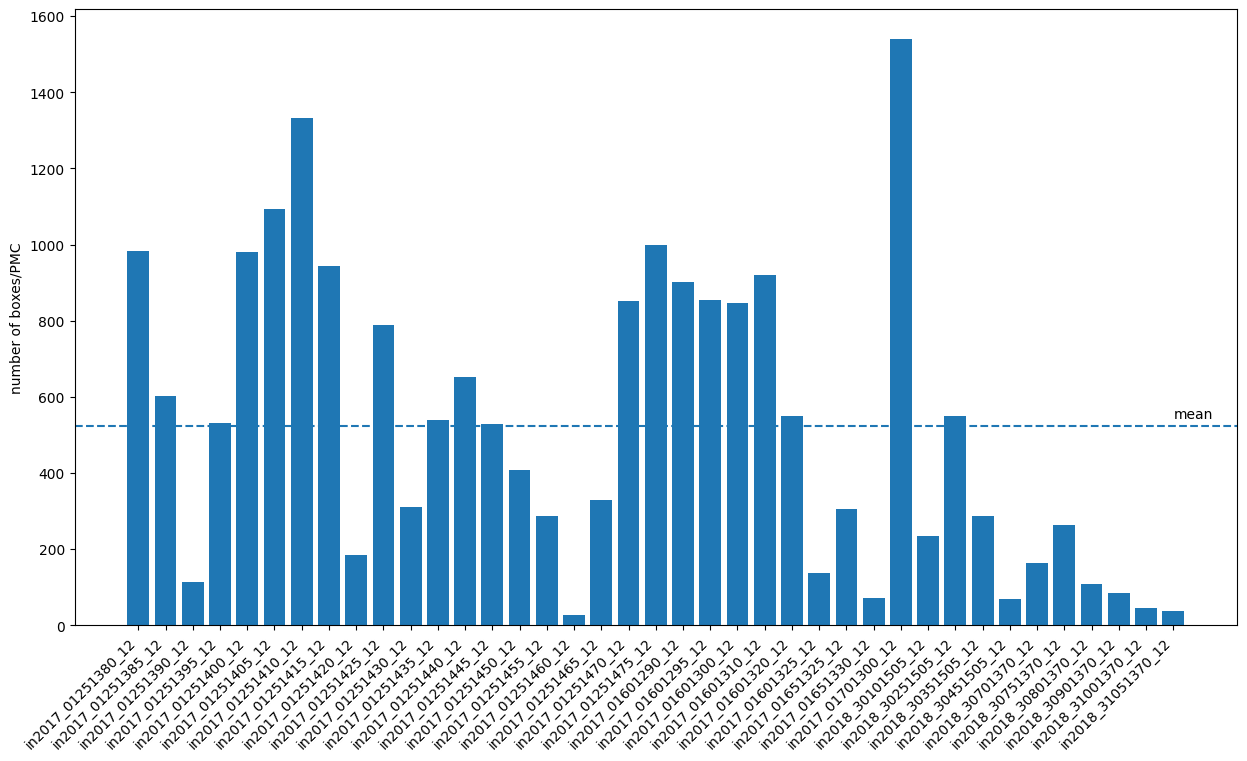

In [63]:
mean = np.mean(list(count.values()))
plt.figure(figsize=(15, 8))
plt.bar(list(count.keys()), list(count.values()))
plt.axhline(y=mean, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.annotate('mean', (38, mean+20))
plt.ylabel('number of boxes/PMC');

In [56]:
count = {k[:-4]: [] for k in all_images}
for label in glob.glob('../dataset-train/labels/*.txt'):
    box = get_boxes(label)
    key = '_'.join(label.split('/')[-1].split('_')[:3])
    xcoord = label.split('/')[-1].split('_')[3]
    ycoord = label.split('/')[-1].split('_')[4][:-4]
    if int(xcoord) % 400 == 0 and int(ycoord) % 400 == 0:
        count[key] += [len(box)]

In [57]:
box_per_im = []
for _, v in count.items():
    box_per_im.extend(v)

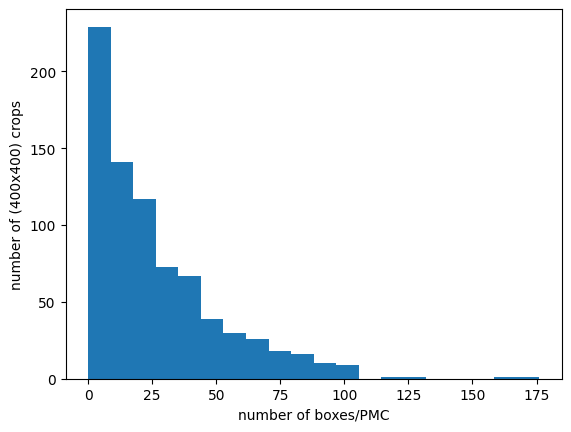

In [59]:
plt.hist(box_per_im, bins=20)
plt.ylabel('number of (400x400) crops')
plt.xlabel('number of boxes/PMC');

# Visualize results

In [168]:
def get_boxes(fname, filter_=False):
    try:
        with open(fname, 'r') as f:
            label = f.read().strip().split('\n')
        if not filter_:
            boxes = list(map(lambda x: [round(float(i), 5) for i in x.split(' ')[1:]], label))
        else:
            boxes = list(filter(lambda x: x[-1] > 0.3, map(lambda x: [round(float(i), 5) for i in x.split(' ')[1:]], label)))
        boxes = np.array(boxes) * 400
        if boxes.any():
            return boxes
        return np.array([])
    except FileNotFoundError:
        return np.array([])

In [178]:
image_path = '../dataset-train/images'
with open('../dataset-train/test.txt', 'r') as f:
    images = sorted(list(map(lambda x: x.split('/')[-1], f.read().strip().split('\n'))))

true_path = '../dataset-train/labels/'
label_path = '../runs/val/exp/labels/'

In [185]:
def get_item(idx):
    im_name = images[idx]
    lab_name = im_name.replace('tif', 'txt')
    
    im = tifffile.imread(os.path.join(image_path, im_name))
    true = get_boxes(os.path.join(true_path, lab_name))
    pred = get_boxes(os.path.join(label_path, lab_name), filter_=True)
    
    return im_name[:-4], im, true, pred

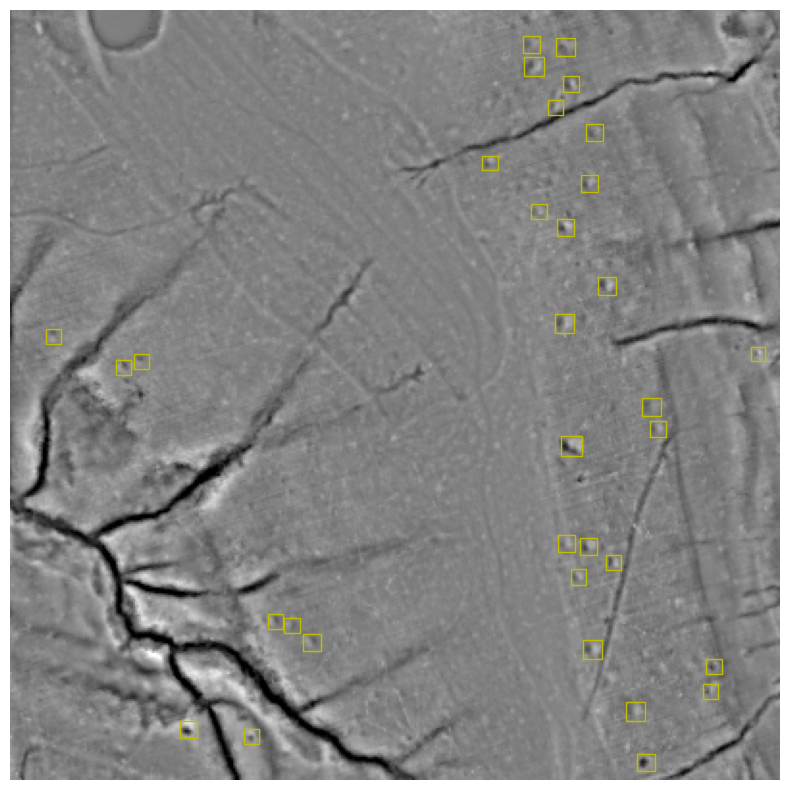

In [186]:
np.random.seed(0)
idx = np.random.choice(len(images), size=1, replace=False).tolist()
    
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

im_name, im, true, pred = get_item(idx[0])

ax.imshow(im[:, :, 0], cmap='gray')
ax.axis('off')

for box in true:
    rect = patches.Rectangle(
        (box[0]-box[2]/2, box[1]-box[3]/2), 
        box[2], box[3], linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)

for box in pred:
    rect = patches.Rectangle(
        (box[0]-box[2]/2, box[1]-box[3]/2), 
        box[2], box[3], linewidth=1, edgecolor='y', facecolor='none'
    )
    ax.add_patch(rect)    

plt.tight_layout()

# Augmentation

In [155]:
import albumentations as A

In [156]:
image_name = '../dataset-train/images_jpg/in2017_01251380_12_400_1600.jpg'
label_name = '../dataset-train/labels/in2017_01251380_12_400_1600.txt'

In [157]:
label = get_boxes(label_name)

In [158]:
im = Image.open(image_name)
im = im.convert('RGB')
im = np.array(im)

In [159]:
def augment(aug):
    transform = A.Compose(
        [aug], 
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
    )
    new = transform(image=im, bboxes=(label/400).tolist(), class_labels=[0]*len(label))
    return new['image'], np.array(new['bboxes']) * 400

In [166]:
blur_image, blur_label = augment(A.Blur(blur_limit=7, always_apply=True))
bright_image, bright_label = augment(A.RandomBrightnessContrast(always_apply=True))
grid_image, grid_label = augment(A.GridDistortion(always_apply=True))
flip_image, flip_label = augment(A.Flip(always_apply=True))
pixel_image, pixel_label = augment(A.PixelDropout(always_apply=True))
rotate_image, rotate_label = augment(A.RandomRotate90(always_apply=True))
sharp_image, sharp_label = augment(A.Sharpen(always_apply=True))
noise_image, noise_label = augment(A.GaussNoise(always_apply=True))

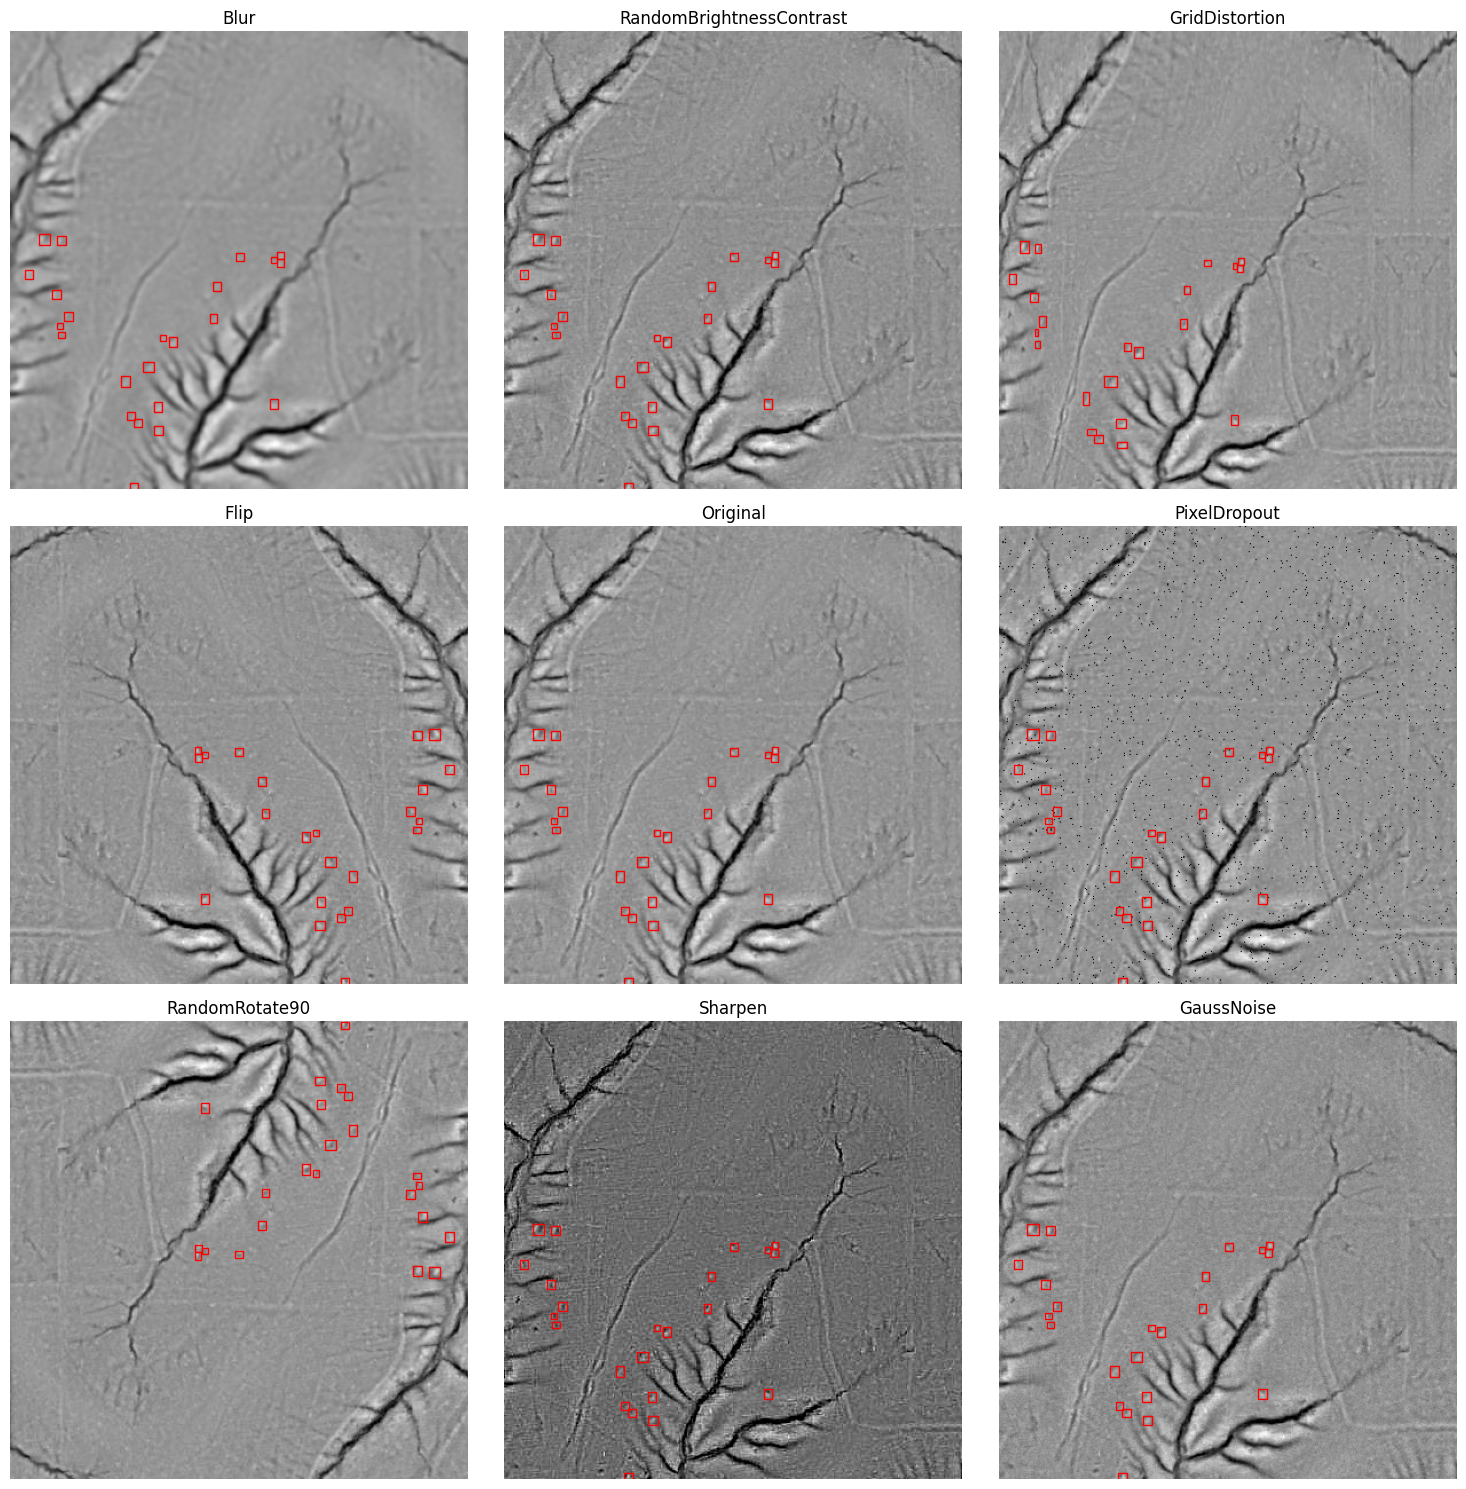

In [167]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

channel = 0

names = ['Blur', 'RandomBrightnessContrast', 'GridDistortion',
        'Flip', 'Original', 'PixelDropout',
        'RandomRotate90', 'Sharpen', 'GaussNoise']
images = [blur_image, bright_image, grid_image, 
          flip_image, im, pixel_image,
         rotate_image, sharp_image, noise_image]
labels = [blur_label, bright_label, grid_label, 
          flip_label, label, pixel_label,
         rotate_label, sharp_label, noise_label]

idx = 0
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(images[idx][:, :, channel], cmap='gray')
        ax[i, j].axis('off')

        for box in labels[idx]:
            rect = patches.Rectangle(
                (box[0]-box[2]/2, box[1]-box[3]/2), 
                box[2], box[3], linewidth=1, edgecolor='r', facecolor='none'
            )
            ax[i, j].add_patch(rect)
        ax[i, j].set_title(names[idx])
        idx += 1

plt.tight_layout()
# plt.show()
# plt.savefig(f'../res/augmentations.jpg', dpi=200)